In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve
from scipy import stats
from scipy.stats import uniform

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

In [2]:
# pip install skorch

In [3]:
X_train = pd.read_csv('X_train_data.csv')
y_train = pd.read_csv('y_train_data.csv')
X_test = pd.read_csv('X_test_data.csv')
y_test = pd.read_csv('y_test_data.csv')

In [4]:
X_test

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,9.871791,114.371450,27912.908263,8.660269,340.046298,490.451835,8.517762,64.831248,3.652264
1,8.331553,238.992414,11635.772076,3.923239,276.402280,406.245129,15.410764,66.396293,2.692389
2,9.534022,201.955208,9472.614920,6.105708,319.576420,259.636803,15.625617,66.396293,2.768239
3,5.736676,180.290908,12683.483292,7.907877,423.876297,415.006576,12.392869,83.707045,2.741791
4,6.427721,166.850237,12215.409083,7.696751,376.282617,352.745370,20.130483,66.735044,2.904453
...,...,...,...,...,...,...,...,...,...
465,6.363836,207.422436,9844.702293,9.765921,320.630725,466.592544,19.156261,58.265305,4.038984
466,7.080795,138.525712,17905.480019,7.929303,399.503611,485.423179,17.667366,36.058262,5.437429
467,8.832142,176.808661,12171.024549,7.475336,321.257628,395.387337,12.481552,65.867189,3.914512
468,7.080795,181.374651,14579.822073,5.435058,333.775777,308.792515,9.545092,60.214647,4.161749


In [5]:
y_test

,Potability
0,0
1,0
2,0
3,1
4,1
...,...
465,0
466,1
467,1
468,0


In [6]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [7]:
X_train

array([[ 0.63957515, -0.97029563, -0.55683796, ...,  1.33077824,
         0.62333532, -0.86514173],
       [ 0.74957579,  0.22000504, -1.03225958, ...,  1.21422757,
         0.8113433 ,  0.36371152],
       [ 2.8731669 ,  1.91297408,  2.6107465 , ..., -0.57048535,
        -0.69414009,  1.19732625],
       ...,
       [-0.56981278, -0.75884719,  2.26772292, ...,  1.35476621,
        -0.10512687, -0.33680143],
       [ 0.76096198, -0.43759225, -1.33917552, ..., -0.17633472,
         0.73604217, -1.82577489],
       [-0.05234353, -0.91778607, -0.45676963, ..., -1.09974938,
        -1.39059198,  0.17667365]])

In [8]:
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

As our data is ready to perform on the model, let us build the same models which we have built in intial analysis

# SVM Model

In [9]:
%%time

SVC_model = SVC(C= 1.2,gamma = 'scale', kernel = 'poly',degree= 4)

# Fitting our data
SVC_model.fit(X_train,y_train)

# Predicting on our test data
SVC_predict= SVC_model.predict(X_test)

# Checking the score
SVC_score = accuracy_score(y_test, SVC_predict)

# Printing the test score
print('Testing score:',SVC_score)

/Users/tharunguduguntla/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Testing score: 0.7
CPU times: user 284 ms, sys: 10.9 ms, total: 295 ms
Wall time: 301 ms


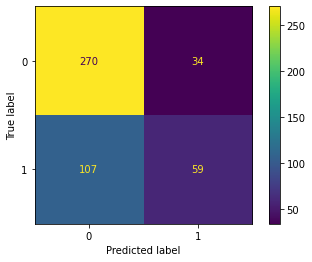

In [10]:
plot_confusion_matrix(SVC_model,X_test,y_test)

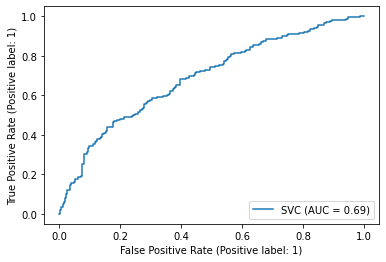

In [11]:
plot_roc_curve(SVC_model,X_test,y_test)

# MLP model

In [12]:
# Converting arrays to Tensor
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

In [13]:
# Reducing the array size
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [14]:
# Converting the reduced array to tensor
y_train = torch.tensor(np.array(y_train))
y_test = torch.tensor(np.array(y_test))

In [15]:
y_test.shape

torch.Size([470])

In [16]:
# Parameters needed for our perceptron network
input_dim = X_train.shape[1]
hidden_dim = 150
output_dim = 2
dropout = 0.4
activation = F.relu

In [17]:
# Building a network
class MLP(nn.Module):
    def __init__(
            self,
            input_size = input_dim,
            hidden_size = hidden_dim,
            output_size = output_dim,
            dropout = dropout,
            activation = activation
    ):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output_size = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = self.activation(self.fc1(X))
        X = self.dropout(X)
        X = self.activation(self.fc2(X))
        X = self.dropout(X)
        X = F.softmax(self.output_size(X), dim = -1)
        
        return X


In [18]:
# Best Parameters we found
batch_size = 250
lr = 0.001
epochs = 400
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss()

In [19]:
# Fitting the parameters and building the model
torch.manual_seed(0)

MLP_model = NeuralNetClassifier(MLP,
                               max_epochs = epochs,
                               batch_size = batch_size,
                               optimizer = optimizer,
                               criterion = criterion,
                               lr = lr,
                               callbacks = [EarlyStopping()]
                              )
# Fitting our model to the data
MLP_model.fit(X_train.float(), y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6829       0.6128        0.6671  0.0447
      2        0.6707       0.6128        0.6672  0.0413
      3        0.6687       0.6128        0.6649  0.0398
      4        0.6664       0.6128        0.6628  0.0393
      5        0.6623       0.6128        0.6606  0.0393
      6        0.6618       0.6147        0.6582  0.0400
      7        0.6605       0.6147        0.6552  0.0395
      8        0.6552       0.6165        0.6517  0.0403
      9        0.6500       0.6278        0.6469  0.0405
     10        0.6459       0.6429        0.6418  0.0411
     11        0.6434       0.6504        0.6369  0.0412
     12        0.6341       0.6635        0.6320  0.0422
     13        0.6323       0.6617        0.6277  0.0414
     14        0.6286       0.6692        0.6247  0.0413
     15        0.6270       0.6729        0.6218  0.0406
     16        0.6267       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (dropout): Dropout(p=0.4, inplace=False)
    (fc1): Linear(in_features=9, out_features=150, bias=True)
    (fc2): Linear(in_features=150, out_features=150, bias=True)
    (output_size): Linear(in_features=150, out_features=2, bias=True)
  ),
)

In [20]:
# Making predictions on the test data set
MLP_predict = MLP_model.predict(X_test.float())

# Checking how well did our model performed
MLP_score = accuracy_score(y_test, MLP_predict)
# Printing the result
print('Testing Score:',MLP_score)

Testing Score: 0.6957446808510638


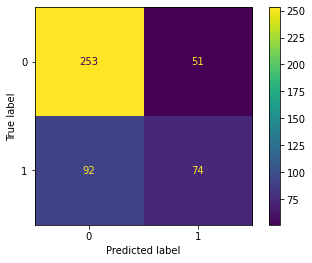

In [21]:
plot_confusion_matrix(MLP_model,X_test.float(),y_test);

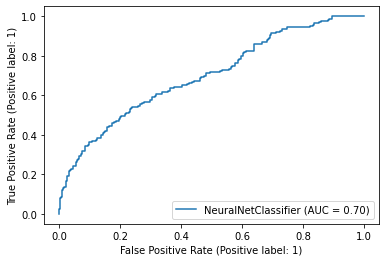

In [22]:
plot_roc_curve(MLP_model,X_test.float(),y_test);

Two models performance has been tested on the test dataset and Confusion Matrices and ROC curves are plotted